In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



def resize_image(image, target_size=(800, 1000)):
    """
    Resize the image while maintaining its aspect ratio.

    Parameters:
      - image (ndarray): Input image to be resized.
      - target_size (tuple): Target size for the image as (height, width).

    Returns:
      - resized_image (ndarray): Resized image with maintained aspect ratio.
    """
    h, w = image.shape[:2]
    scale = min(target_size[1] / w, target_size[0] / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    return resized_image


def logarithmic_transformation(image, epsilon=1e-5):
    """
      Apply logarithmic transformation to enhance the image contrast, with zero values handling.

      Parameters:
        - image (ndarray): Input image.
        - epsilon (float): Small value added to avoid log(0), defaults to 1e-5.

      Returns:
        - log_image (ndarray): Logarithmically transformed image.
    """
    c = 255 / np.log(1 + np.max(image))
    # Epsilon zero-handling technique
    log_image = c * (np.log(1 + image + epsilon))
    log_image = np.array(log_image, dtype=np.uint8)

    return log_image


def contrast_stretching(image):
    """
    Perform contrast stretching to improve contrast.

    Parameters:
      - image (ndarray): Input grayscale image.

    Returns:
      - stretched (ndarray): Contrast-stretched image.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    stretched = (image - min_val) * (255 / (max_val - min_val))
    return stretched.astype(np.uint8)


def gaussian_blur(image, mode='Soft'):
    """
    Apply Gaussian blur to the image with varying strength.

    Parameters:
      - image (ndarray): Input image.
      - mode (str): Blurring strength, can be 'Soft', 'Medium', or 'Hard'.

    Returns:
      - blurred_image (ndarray): Blurred image.
    """
    if mode == 'Soft':
        kernel_size = (3, 3)
    elif mode == 'Medium':
        kernel_size = (5, 5)
    elif mode == 'Hard':
        kernel_size = (7, 7)
    else:
        raise ValueError("Mode must be 'Soft', 'Medium', or 'Hard'")

    return cv2.GaussianBlur(image, kernel_size, 0)


def measure_blurriness(image):
    """
    Measure the blurriness of the image using the Laplacian operator.

    Parameters:
      - image (ndarray): Input grayscale image.

    Returns:
      - variance (float): Variance of the Laplacian, representing the image sharpness.
    """
    # Laplacian operator fpr edge detection
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    # Laplacian variance
    variance = laplacian.var()

    return variance


def adaptive_gaussian_blur(image, desired_blur=100, max_iterations=100):
    """
    Apply Gaussian blur adaptively until a specified level of blurriness is achieved.

    Parameters:
      - image (ndarray): Input grayscale image.
      - desired_blur (float): Target blurriness level.
      - max_iterations (int): Maximum iterations to achieve the desired blur.

    Returns:
      - final_blurred_img (ndarray): Blurred image meeting the desired blur criteria.
    """
    # initial blur level
    initial_blur = measure_blurriness(image)

    # start kernel size
    kernel_size = 5

    for iteration in range(max_iterations):
        blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        current_blur = measure_blurriness(blurred_image)

        # stop if current blur exceeds desired blur
        if current_blur > desired_blur:
            kernel_size += 2
        else:
            break

    final_blurred_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    final_blur = measure_blurriness(final_blurred_img)

    print(
        f"Initial Blur: {initial_blur}, Final Blur: {final_blur}, Kernel Size: {kernel_size}, Iterations: {iteration+1}")

    return final_blurred_img


def clahe_equalization(image):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to the image.

    Parameters:
      - image (ndarray): Input grayscale image.

    Returns:
      - equalized_img (ndarray): CLAHE-equalized image.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(image)
    return equalized_img


def otsu_thresholding(image):
    """
    Apply Otsu's thresholding method to binarize the image.

    Parameters:
      - image (ndarray): Input grayscale image.

    Returns:
      - binary_image (ndarray): Binarized image using Otsu's thresholding.
    """
    _, binary_image = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary_image


def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    """
    Detect edges in the image using the Canny edge detection algorithm.

    Parameters:
      - image (ndarray): Input grayscale image.
      - low_threshold (int): Low threshold for Canny edge detection.
      - high_threshold (int): High threshold for Canny edge detection.

    Returns:
      - edges (ndarray): Edge-detected image.
    """
    return cv2.Canny(image, low_threshold, high_threshold)


def find_extreme_corners(contours):
    """
    Find the extreme corners (top-left, top-right, bottom-left, bottom-right) of the image based on contours.

    Parameters:
      - contours (list): List of contours detected in the image.

    Returns:
      - corners (tuple): Four corner points (top-left, top-right, bottom-left, bottom-right) as tuples.
    """
    all_points = np.vstack(contours)
    top_left = all_points[np.argmin(all_points[:, :, 0] + all_points[:, :, 1])]
    bottom_right = all_points[np.argmax(
        all_points[:, :, 0] + all_points[:, :, 1])]
    top_right = all_points[np.argmax(
        all_points[:, :, 0] - all_points[:, :, 1])]
    bottom_left = all_points[np.argmin(
        all_points[:, :, 0] - all_points[:, :, 1])]
    return top_left[0], top_right[0], bottom_left[0], bottom_right[0]


def apply_perspective_transformation(image, corners):
    """
    Apply perspective transformation to the image based on the provided corner points.

    Parameters:
      - image (ndarray): Input image.
      - corners (tuple): Coordinates of the four corners to transform.

    Returns:
      - warped (ndarray): Warped image after perspective transformation.
    """
    tl, tr, bl, br = corners
    width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
    height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

    dst_pts = np.array([
        [0, 0],
        [width - 1, 0],
        [0, height - 1],
        [width - 1, height - 1]
    ], dtype="float32")

    src_pts = np.array([tl, tr, bl, br], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped


def automatic_warp_transformation(image, target_size=(800, 1000)):
    """
    Perform automatic warp transformation for document alignment and resizing.

    Parameters:
      - image (ndarray): Input image.
      - target_size (tuple): Target size as (height, width) for resizing.

    Returns:
      - warped_image (ndarray): Warped and resized image.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = resize_image(gray_image, target_size)
    brightened_image = logarithmic_transformation(resized_image)
    contrast_image = contrast_stretching(brightened_image)
    blurred_image = gaussian_blur(contrast_image, mode='Soft')
    binary_image = otsu_thresholding(blurred_image)
    edges = canny_edge_detection(binary_image)
    contours, _ = cv2.findContours(
        edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Getting Contours (Drawing Contours in image, useful for debugging)
    contour_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    corners = find_extreme_corners(contours)
    for corner in corners:
        cv2.circle(contour_image, tuple(corner), 5, (0, 0, 255), -1)

    warped_image = apply_perspective_transformation(resized_image, corners)
    print(f'Initial image {image.shape} processed to {warped_image.shape}')

    return warped_image


def automatic_warp_transformation_v2(image, target_size=(800, 1000)):
    """
    Improved document alignment implementing additional preprocessing.

    Parameters:
      - image (ndarray): Input image.
      - target_size (tuple): Target size as (height, width) for resizing.

    Returns:
      - warped_image (ndarray): Warped and resized image.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = resize_image(gray_image, target_size)

    clahe = clahe_equalization(resized_image)
    log_img = logarithmic_transformation(clahe)
    contrast_img = contrast_stretching(log_img)
    blurred_img = gaussian_blur(contrast_img)
    binary_img = otsu_thresholding(blurred_img)
    edges = canny_edge_detection(binary_img)
    contours, _ = cv2.findContours(
        edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Getting Contours (Drawing Contours in image, useful for debugging)
    contour_image = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    corners = find_extreme_corners(contours)
    for corner in corners:
        cv2.circle(contour_image, tuple(corner), 5, (0, 0, 255), -1)

    warped_image = apply_perspective_transformation(resized_image, corners)
    print(f'Initial image {image.shape} processed to {warped_image.shape}')

    return warped_image


def image_uniformization(master_image, student_image):
    """
    Resize both master and student images to a uniform size for comparison.

    Parameters:
      - master_image (ndarray): Image of the answer key.
      - student_image (ndarray): Image of the student's answers.

    Returns:
      - resized_master (ndarray): Resized master image.
      - resized_student (ndarray): Resized student image.
    """
    master_shape = master_image.shape
    student_shape = student_image.shape

    master_height = master_shape[0]
    master_width = master_shape[1]

    student_height = student_shape[0]
    student_width = student_shape[1]

    min_height = min(master_height, student_height)
    min_width = min(master_width, student_width)

    resized_master = cv2.resize(master_image, (min_width, min_height))
    resized_student = cv2.resize(student_image, (min_width, min_height))

    print(
        f'master_key {master_image.shape} and student_answer {student_image.shape} uniformed to {resized_master.shape}')

    return resized_master, resized_student


def morph_open(image):
    """
    Apply morphological opening to remove noise from the image.

    Parameters:
      - image (ndarray): Input binary image.

    Returns:
      - dilated_img (ndarray): Image after applying morphological opening.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    eroded_img = cv2.erode(image, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    return dilated_img


def soft_morph_open(image):
    """
    Apply a softer morphological opening operation to the image to remove light noise.

    Parameters:
      - image (ndarray): Input binary image.

    Returns:
      - dilated_img (ndarray): Image after applying soft morphological opening.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded_img = cv2.erode(image, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    return dilated_img


def core_preprocessing(image):
    """
    Core preprocessing pipeline for preparing the image.

    Parameters:
      - image (ndarray): Input grayscale image.

    Returns:
      - opened_img (ndarray): Preprocessed binary image.
    """
    blurred_img = gaussian_blur(image, mode='Hard')
    contrast_img = contrast_stretching(blurred_img)
    log_img = logarithmic_transformation(contrast_img)
    binary_img = otsu_thresholding(log_img)
    opened_img = morph_open(binary_img)

    return opened_img


def core_preprocessing_v2(image):
    """
    Improved core processing pipeline, implementing better preprocessing

    Parameters:
      - image (ndarray): Input grayscale image.

    Returns:
      - opened_img (ndarray): Preprocessed binary image.
    """
    clahe_img = clahe_equalization(image)
    blurred_img = adaptive_gaussian_blur(
        clahe_img, desired_blur=100, max_iterations=100)
    contrast_img = contrast_stretching(blurred_img)
    log_img = logarithmic_transformation(contrast_img)
    binary_img = otsu_thresholding(log_img)
    opened_img = morph_open(binary_img)

    return opened_img
  

def draw_full_contours(contours, cont_image, radius=7):
    """
    Draws filled circles at the center of each contour on the given image.

    Parameters:
      - contours (list): List of contours to be drawn.
      - cont_image (numpy.ndarray): Image on which contours will be drawn.
      - radius (int): Radius of the filled circles to be drawn at the contour centers.

    Returns:
      - numpy.ndarray: Image with contours drawn as filled circles.
    """
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            # draw filled circle at contour center
            cv2.circle(cont_image, (cX, cY), radius, (0, 255, 0), -1)

    return cont_image


def extract_and_draw_contours(image):
    """
    Extracts all contours from an image and draws filled circles at each contour center.

    Parameters:
      - image (numpy.ndarray): Input binary or grayscale image for contour extraction.

    Returns:
        tuple: (contours, contour_image)
            - contours (list): List of contours detected in the image.
            - contour_image (numpy.ndarray): Image with drawn contours as filled circles.
    """
    contours, _ = cv2.findContours(
        image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    unique_values = []
    for columns in image:
        for pixel in columns:
            if pixel not in unique_values:
                unique_values.append(pixel)

    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    contour_image = draw_full_contours(contours, contour_image)

    return contours, contour_image


def extract_and_draw_circle_contours(image):
    """
    Extracts contours from an image and filters them to find circular contours.
    Draws filled circles at the center of each circular contour.

    Parameters:
      - image (numpy.ndarray): Input binary or grayscale image for circular contour extraction.

    Returns:
        tuple: (circle_contours, contour_image)
            - circle_contours (list): List of contours approximated as circles.
            - contour_image (numpy.ndarray): Image with drawn circular contours as filled circles.
    """
    contours, _ = cv2.findContours(
        image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    circle_contours = []
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for contour in contours:
        # approximate the enclosing circle for each contour
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circle_area = np.pi * (radius ** 2)

        # compute actual contour area
        contour_area = cv2.contourArea(contour)

        # 'circular' tolerance
        if radius < 5:
            if 0.6 <= contour_area / circle_area <= 1.4:
                circle_contours.append(contour)
        else:
            if 0.8 <= contour_area / circle_area <= 1.2:
                circle_contours.append(contour)

    contour_image = draw_full_contours(circle_contours, contour_image)

    return circle_contours, contour_image


def final_scoring(new_student, processed_student, master_contours):
    """
    Evaluates student answers by comparing with master contours, and scores based on detected differences.

    Parameters:
      - new_student (numpy.ndarray): Student's answer image.
      - processed_student (numpy.ndarray): Preprocessed student's answer image.
      - master_contours (list): Contours from the master answer key image.

    Returns:
        tuple: (stu_final_score, student_correction, detected_total_questions, detected_mistakes)
            - stu_final_score (float): The final score for the student.
            - student_correction (list): List of corrections for student answers.
            - detected_total_questions (int): Total number of detected questions.
            - detected_mistakes (int): Number of detected mistakes in the student's answers.
    """
    # processing mistake location and count
    test_answer = processed_student.copy()
    check_answers = draw_full_contours(master_contours, test_answer)
    final_sheet = morph_open(check_answers)
    final_contours, _ = extract_and_draw_circle_contours(final_sheet)

    # mistakes, etc. computation
    mistakes = len(final_contours)
    total_questions = len(master_contours)
    print(f'total_questions: {total_questions}, mistakes: {mistakes}')
    final_score = ((total_questions - mistakes) / total_questions) * 100
    print(f'final score: {final_score}')

    # retrieve student correction
    student_correction = cv2.cvtColor(new_student, cv2.COLOR_GRAY2BGR)
    student_correction = draw_full_contours(
        master_contours, student_correction)

    return final_score, student_correction, total_questions, mistakes

(794, 2703, 3)


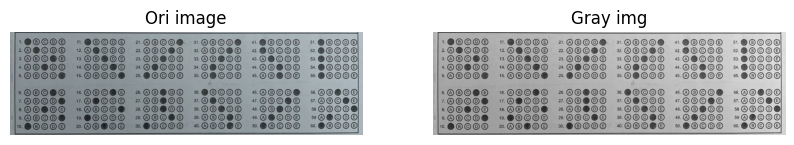

In [99]:
answer1 = cv2.imread('C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/inputs/circs/master1_crop.jpg')
master_sheet = cv2.imread('C:/Users/vian8/Desktop/Tugas2/SNAPGRADE/inputs/circs/master1_crop.jpg')

# answer1 = cv2.imread('inputs/circle_2/student1_crop.jpg')
# master_sheet = cv2.imread('inputs/circle_2/master1_crop.jpg')

print(master_sheet.shape)
# MASTER KEY
gray_img = cv2.cvtColor(master_sheet, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(master_sheet, cmap='gray')
plt.title('Ori image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray img')
plt.axis('off')

plt.show()

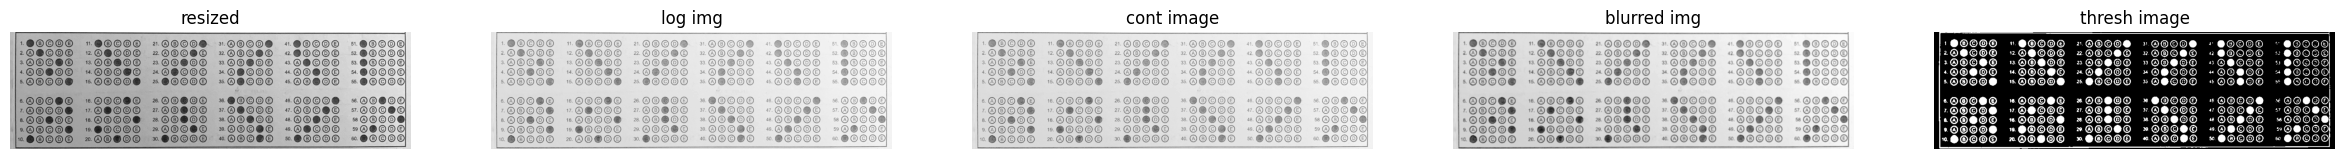

In [100]:
resized = resize_image(gray_img)
log_img = logarithmic_transformation(resized)
contrast_img = contrast_stretching(log_img)
blurred_img = gaussian_blur(contrast_img)
# blurred_img = adaptive_gaussian_blur(contrast_img)
binary_img = otsu_thresholding(blurred_img)

plt.figure(figsize = (30, 20))

plt.subplot(1, 5, 1)
plt.imshow(resized, cmap='gray')
plt.title('resized')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(log_img, cmap='gray')
plt.title('log img')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(contrast_img, cmap='gray')
plt.title('cont image')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(blurred_img, cmap='gray')
plt.title('blurred img')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(binary_img, cmap='gray')
plt.title('thresh image')
plt.axis('off')

plt.show()

In [101]:
blurriness = measure_blurriness(blurred_img)
print('Blurriness: ', blurriness)

Blurriness:  507.9444681959721


Initial image (794, 2703, 3) processed to (291, 974)
Initial image (794, 2703, 3) processed to (291, 974)
master_sheet (794, 2703, 3) processed to (291, 974)
answer1 (794, 2703, 3) processed to (291, 974)


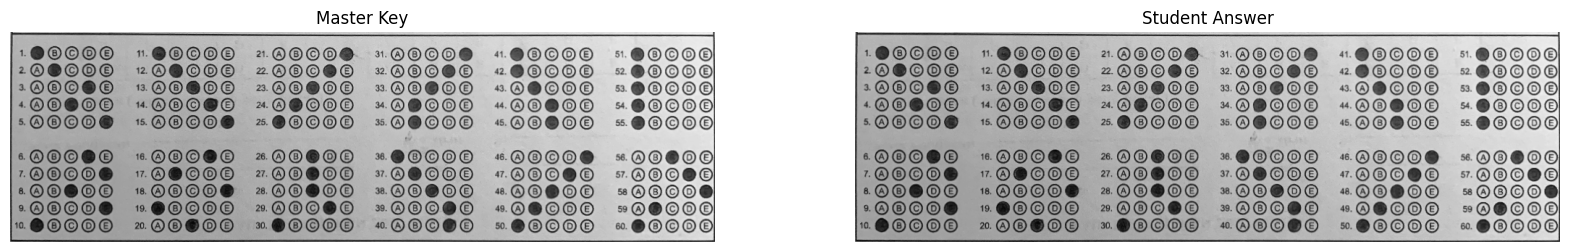

In [102]:
student1 = automatic_warp_transformation(answer1)
master_key = automatic_warp_transformation(master_sheet)

print(f'master_sheet {master_sheet.shape} processed to {master_key.shape}')
print(f'answer1 {answer1.shape} processed to {student1.shape}')

plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.imshow(master_key, cmap='gray')
plt.title('Master Key')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(student1, cmap='gray')
plt.title('Student Answer')
plt.axis('off')

plt.show()

In [103]:
new_master, new_student = image_uniformization(master_key, student1)
print(new_master.shape, new_student.shape)

master_key (291, 974) and student_answer (291, 974) uniformed to (291, 974)
(291, 974) (291, 974)


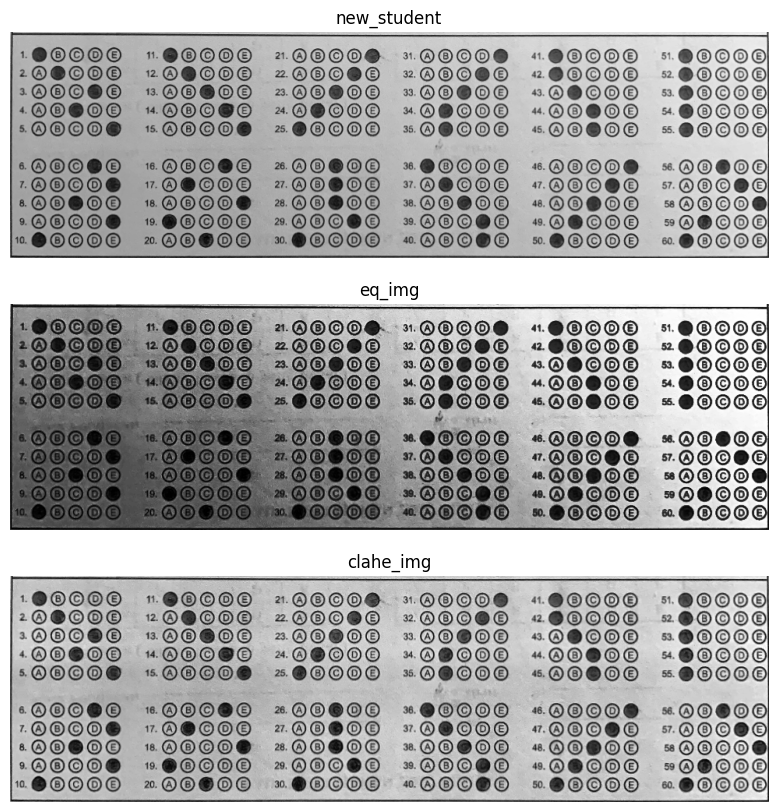

In [104]:
def histogram_equalization(image):
  equalized_img = cv2.equalizeHist(image)
  return equalized_img

eq_img = histogram_equalization(new_student)
clahe_img = clahe_equalization(new_student)

plt.figure(figsize = (15, 10))

plt.subplot(3, 1, 1)
plt.imshow(new_student, cmap='gray')
plt.title('new_student')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(eq_img, cmap='gray')
plt.title('eq_img')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(clahe_img, cmap='gray')
plt.title('clahe_img')
plt.axis('off')

plt.show()

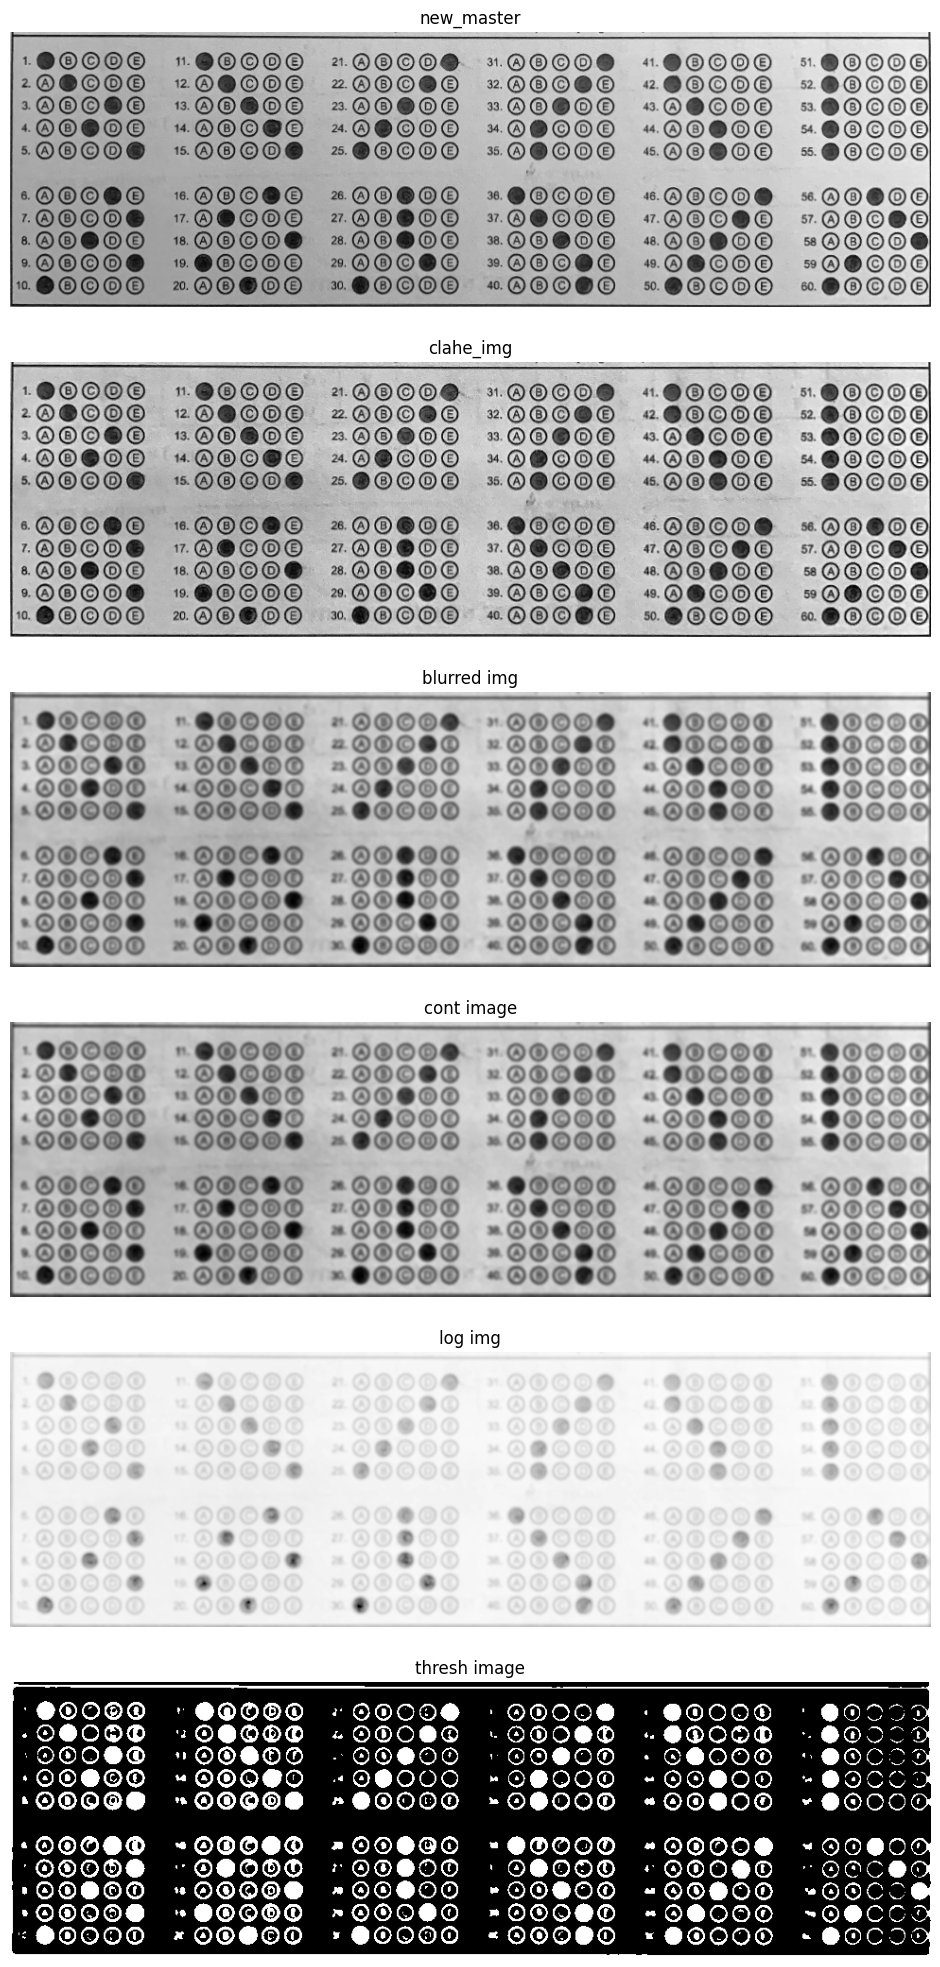

Blurriness:  122.77851539689347


In [105]:
clahe_img = clahe_equalization(new_master)
blurred_img = gaussian_blur(clahe_img, mode='Hard')
contrast_img = contrast_stretching(blurred_img)
log_img = logarithmic_transformation(contrast_img)
binary_img = otsu_thresholding(log_img)

plt.figure(figsize=(15, 25))

plt.subplot(6, 1, 1)
plt.imshow(new_master, cmap='gray')
plt.title('new_master')
plt.axis('off')

plt.subplot(6, 1, 2)
plt.imshow(clahe_img, cmap='gray')
plt.title('clahe_img')
plt.axis('off')

plt.subplot(6, 1, 3)
plt.imshow(blurred_img, cmap='gray')
plt.title('blurred img')
plt.axis('off')

plt.subplot(6, 1, 4)
plt.imshow(contrast_img, cmap='gray')
plt.title('cont image')
plt.axis('off')

plt.subplot(6, 1, 5)
plt.imshow(log_img, cmap='gray')
plt.title('log img')
plt.axis('off')

plt.subplot(6, 1, 6)
plt.imshow(binary_img, cmap='gray')
plt.title('thresh image')
plt.axis('off')

plt.show()

blurriness = measure_blurriness(blurred_img)
print('Blurriness: ', blurriness)

Initial Blur: 3564.0861691289438, Final Blur: 59.248868623219415, Kernel Size: 9, Iterations: 3


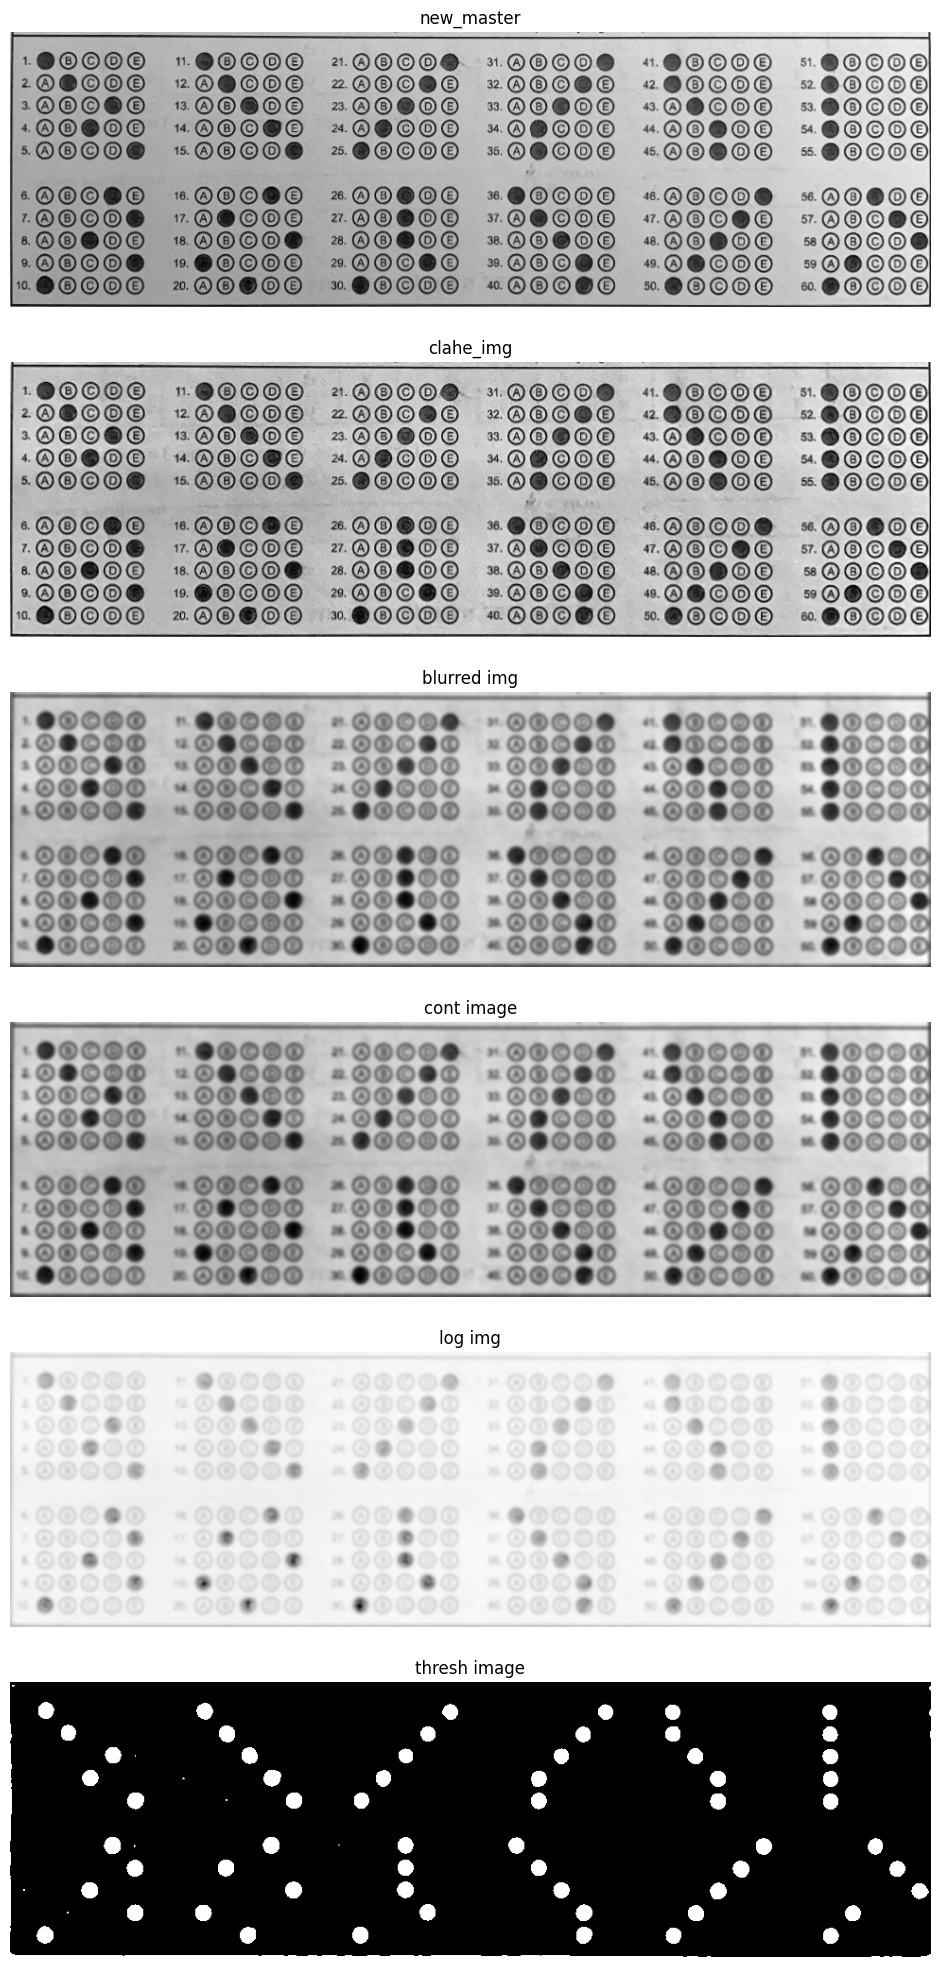

Blurriness:  59.248868623219415


In [106]:
# Example pipeline with improved adaptive Gaussian blur
clahe_img = clahe_equalization(new_master)
blurred_img = adaptive_gaussian_blur(clahe_img, desired_blur=100, max_iterations=100)
contrast_img = contrast_stretching(blurred_img)
log_img = logarithmic_transformation(contrast_img)
binary_img = otsu_thresholding(log_img)

plt.figure(figsize=(15, 25))

plt.subplot(6, 1, 1)
plt.imshow(new_master, cmap='gray')
plt.title('new_master')
plt.axis('off')

plt.subplot(6, 1, 2)
plt.imshow(clahe_img, cmap='gray')
plt.title('clahe_img')
plt.axis('off')

plt.subplot(6, 1, 3)
plt.imshow(blurred_img, cmap='gray')
plt.title('blurred img')
plt.axis('off')

plt.subplot(6, 1, 4)
plt.imshow(contrast_img, cmap='gray')
plt.title('cont image')
plt.axis('off')

plt.subplot(6, 1, 5)
plt.imshow(log_img, cmap='gray')
plt.title('log img')
plt.axis('off')

plt.subplot(6, 1, 6)
plt.imshow(binary_img, cmap='gray')
plt.title('thresh image')
plt.axis('off')

plt.show()

blurriness = measure_blurriness(blurred_img)
print('Blurriness: ', blurriness)

In [107]:
# cv2_imshow(new_master)

In [108]:
# cv2_imshow(new_student)

Initial Blur: 3564.0861691289438, Final Blur: 59.248868623219415, Kernel Size: 9, Iterations: 3
Initial Blur: 3564.0861691289438, Final Blur: 59.248868623219415, Kernel Size: 9, Iterations: 3


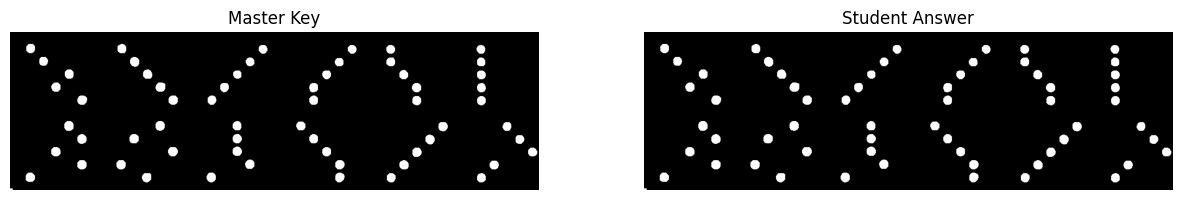

In [109]:
processed_master = core_preprocessing_v2(new_master)
processed_student = core_preprocessing_v2(new_student)

plt.figure(figsize = (15, 10))

plt.subplot(1, 2, 1)
plt.imshow(processed_master, cmap='gray')
plt.title('Master Key')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_student, cmap='gray')
plt.title('Student Answer')
plt.axis('off')

plt.show()

In [110]:
# cv2_imshow(processed_student)

61
61


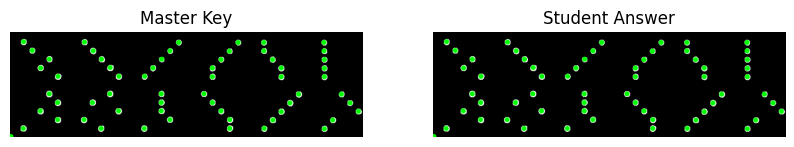

In [111]:
student_contours, student_contour_image = extract_and_draw_contours(processed_student)
master_contours, master_contour_image = extract_and_draw_contours(processed_master)

print(len(student_contours))
print(len(master_contours))

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(master_contour_image, cmap='gray')
plt.title('Master Key')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(student_contour_image, cmap='gray')
plt.title('Student Answer')
plt.axis('off')

plt.show()

In [112]:
# cv2_imshow(master_contour_image)

In [113]:
print(student_contour_image.shape, master_contour_image.shape)

(291, 974, 3) (291, 974, 3)


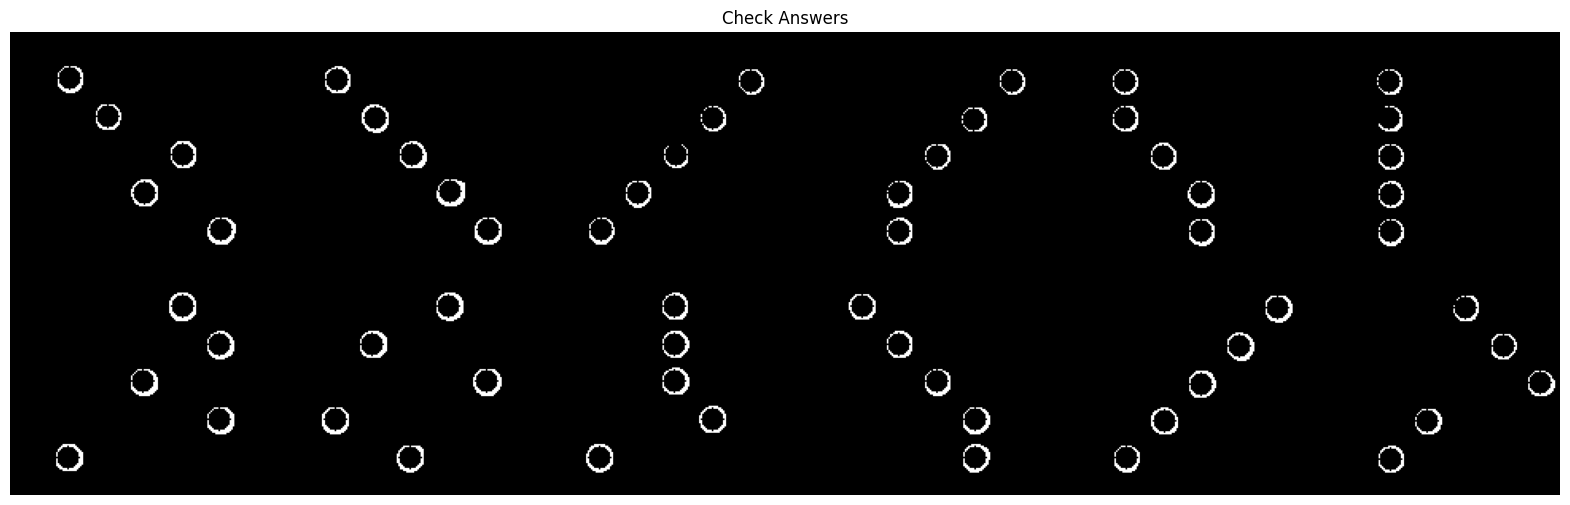

In [114]:
test_answer = processed_student.copy()
# check_answers = cv2.drawContours(test_answer, master_contours, -1, (0, 255, 0), 7)
check_answers = draw_full_contours(master_contours, processed_student)

plt.figure(figsize = (20, 10))

plt.imshow(check_answers, cmap='gray')
plt.title('Check Answers')
plt.axis('off')

plt.show()

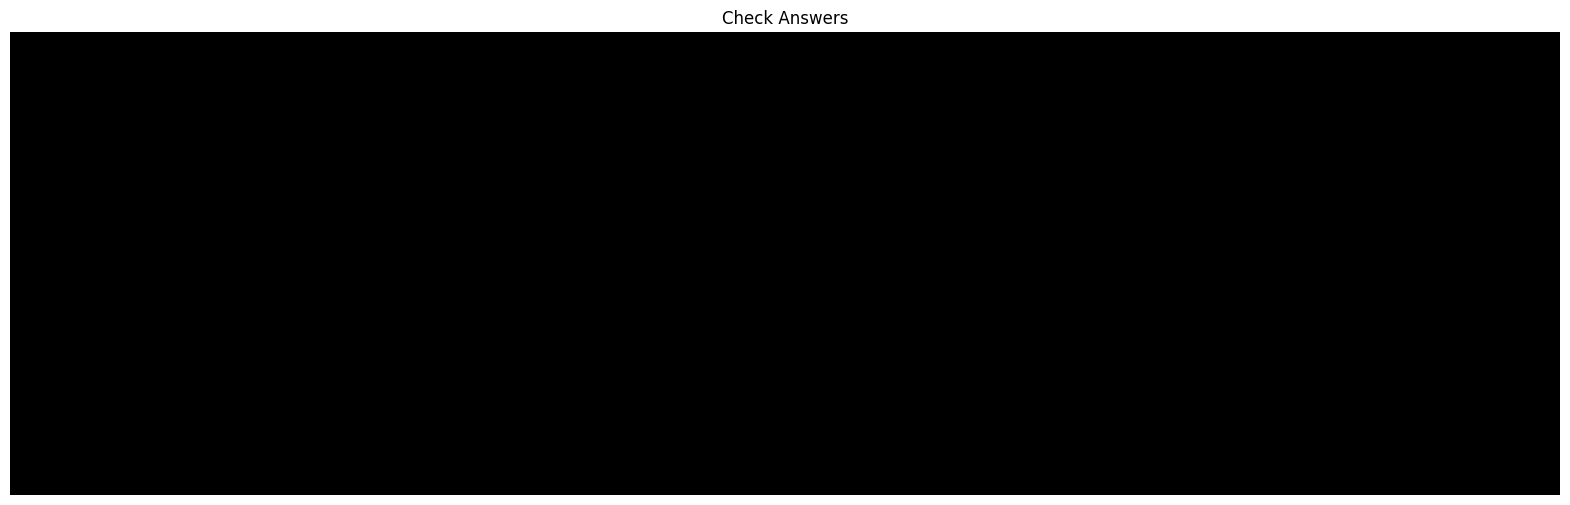

In [115]:
final_sheet = morph_open(check_answers)
final_contours, _ = extract_and_draw_circle_contours(final_sheet)

plt.figure(figsize = (20, 10))

plt.imshow(final_sheet, cmap='gray')
plt.title('Check Answers')
plt.axis('off')

plt.show()

total_questions: 61, mistakes: 0
final score: 100.0


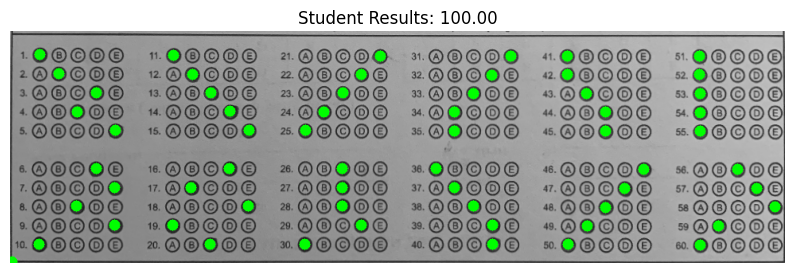

In [116]:
stu_final_score, stu_answer_key, total_questions, mistakes = final_scoring(new_student, processed_student, master_contours)
# cv2_imshow(stu_answer_key)

plt.figure(figsize = (10, 5))

plt.imshow(stu_answer_key, cmap='gray')
plt.title(f'Student Results: {"{:.2f}".format(stu_final_score)}')
plt.axis('off')

plt.show()